# Topic modelling on train travel comments dataset

## 1. Set up environment and load dataset

In [90]:
import json
import warnings
from typing import List, Any

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook
import gensim
import tqdm
import nltk
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.utils import simple_preprocess, ClippedCorpus
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Phrases, CoherenceModel
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
plt.style.use("ggplot") 
warnings.filterwarnings(action="ignore", category=matplotlib.cbook.mplDeprecation)
warnings.simplefilter(action='ignore', category=FutureWarning)

%reload_ext autoreload
%autoreload 2

[nltk_data] Downloading package wordnet to /home/miro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
reviews_file = open("../data/train_reviews.json")
reviews_dict = json.load(reviews_file)

## 2. Basic dataset preprocessing

 - Convert dictionary object into pandas dataframe, normalize `date` column, create `period` column representing **year-month**, **company** column extracted from url and expand `stars` column.

In [92]:
reviews = pd.DataFrame(reviews_dict)

reviews["date"] = pd.to_datetime(reviews['date'])
reviews["period"] = reviews.date.dt.strftime('%Y-%m')
reviews["year"] = reviews.date.dt.year
reviews["company"] = reviews.url.str.replace("https://uk.trustpilot.com/review/www.", "", regex=False).str.split(".", expand=True)[0]

expanded_stars = reviews["stars"].str.split(expand=True).rename(columns={0: 'rating_type', 1: 'rating_id', 2: 'rating_level'})
reviews[expanded_stars.columns] = expanded_stars
reviews = reviews.drop(columns=["stars", "url"])

- Check if all ratings are of the same type and level.

In [93]:
print(f"""The unique rating types and levels are as follows:
{reviews.rating_type.unique().tolist()}, {reviews.rating_level.unique().tolist()}""")

The unique rating types and levels are as follows:
['star-rating'], ['star-rating--medium']


- Drop irrelevant `rating_type`and `rating_level` columns and convert `rating_id` into numeric column.

In [94]:
reviews = reviews.drop(columns={'rating_type', 'rating_level'}, errors='ignore')
if reviews.rating_id.dtype != 'int64':
    reviews['rating_id'] = reviews['rating_id'].str.strip("star-rating").astype(int)
reviews = reviews.reindex(columns=["date", "period", "year", "company", "title", "text", "rating_id"])
reviews.head()

,date,period,year,company,title,text,rating_id
0,2015-10-10 14:32:51+00:00,2015-10,2015,nationalrail,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,1
1,2015-09-22 17:04:56+00:00,2015-09,2015,nationalrail,Pretty awful service,I phoned National rail to find out why several...,1
2,2015-03-13 23:37:05+00:00,2015-03,2015,nationalrail,Awful staff,I travel from Brokenhast to southampton centra...,1
3,2015-01-13 12:26:52+00:00,2015-01,2015,nationalrail,Very good,Saved about £50 on a single trip using Nationa...,4
4,2011-05-28 15:00:36+00:00,2011-05,2011,nationalrail,Check it out.,I always use the national rail enquiry site wh...,4


## 3. Exploratory data analysis

- Since the number of observations in year 2011 is only 2, we will delete that year so that only contiguous period of years 2015-2018 remained.

In [95]:
print(reviews.year.value_counts().tail(1))
reviews = reviews[reviews.year != 2011].reset_index(drop=True)

2011    2
Name: year, dtype: int64


- **Eliminate 580 duplicated reviews** in order not to train model on redundant information.

In [96]:
reviews = reviews.drop_duplicates().reset_index(drop=True)
reviews.shape

(1439, 7)

- Check the ratings distribution over years. We can see the **trend of increased dissatisfaction with the railway service** (on condition that `rating=1` is the worst rating grade). Also, we can see that reviews have been submitted primarily for six companies. **We also see that the overall number of reviews with positive or neutral rating is rather small (~150) so we will keep them in the development sample even though the task was aimed primarily to elicit information from dissatisfied customers (to improve provided service). It can be assumed that reviews from neutral/positive-rating customers can also bring some information value for the companies.**

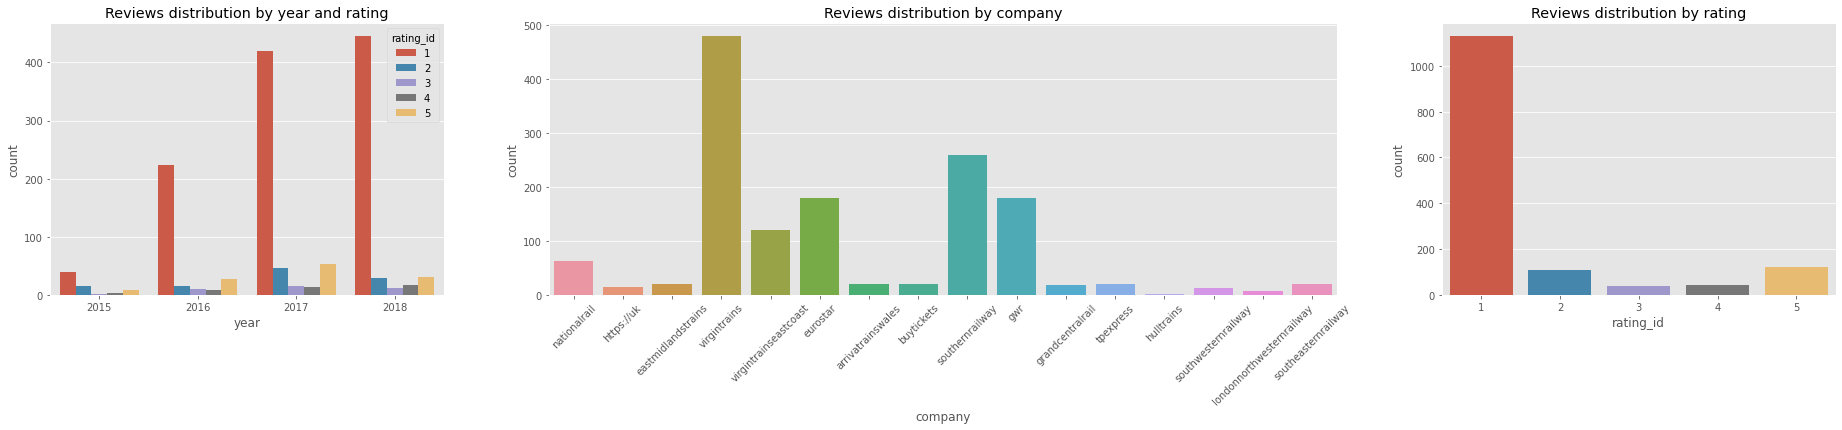

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(32, 5),  gridspec_kw={'width_ratios': [1, 2, 1]})
sns.countplot(x="year", hue="rating_id", data=reviews, ax=axs[0])
axs[0].set_title("Reviews distribution by year and rating")

sns.countplot(x="company", data=reviews, ax=axs[1])
axs[1].set_title("Reviews distribution by company")
axs[1].tick_params(axis="x", rotation=45);

sns.countplot(x="rating_id", data=reviews, ax=axs[2])
axs[2].set_title("Reviews distribution by rating");

- Distribution of reviews by month shows that the **number of reviews increased in first two years, then culminated at around 500 reviews per year.**

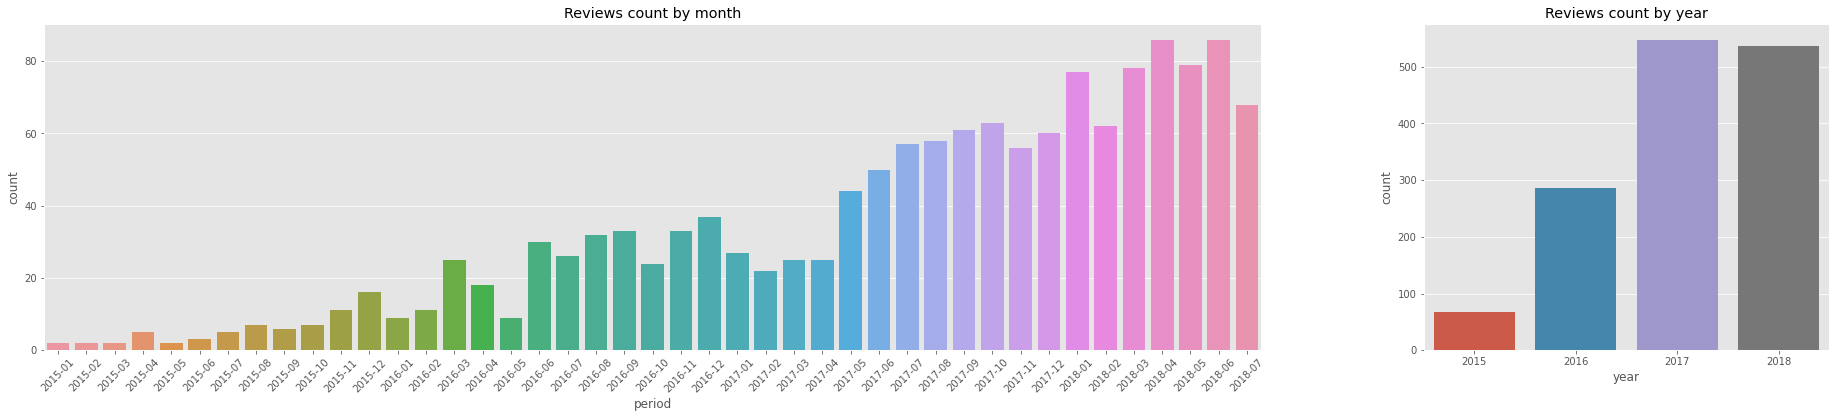

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(32, 6), gridspec_kw={'width_ratios': [3, 1]})
sns.countplot(x="period", data=reviews, order=reviews.period.value_counts().index.sort_values(), ax=axs[0])
axs[0].set_title("Reviews count by month")
axs[0].tick_params(axis="x", rotation=45)
sns.countplot(x="year", data=reviews, ax=axs[1])
axs[1].set_title("Reviews count by year");

- Check the distribution of review title lengths to find out whether, by chance, reviewers did not enter the review into title. At the same time, check the distribution of review text lengths. The means and standard deviations are displayed in figure titles. **Figures show that the reviews are actually restricted to text field and the title can be effectively ignored.**

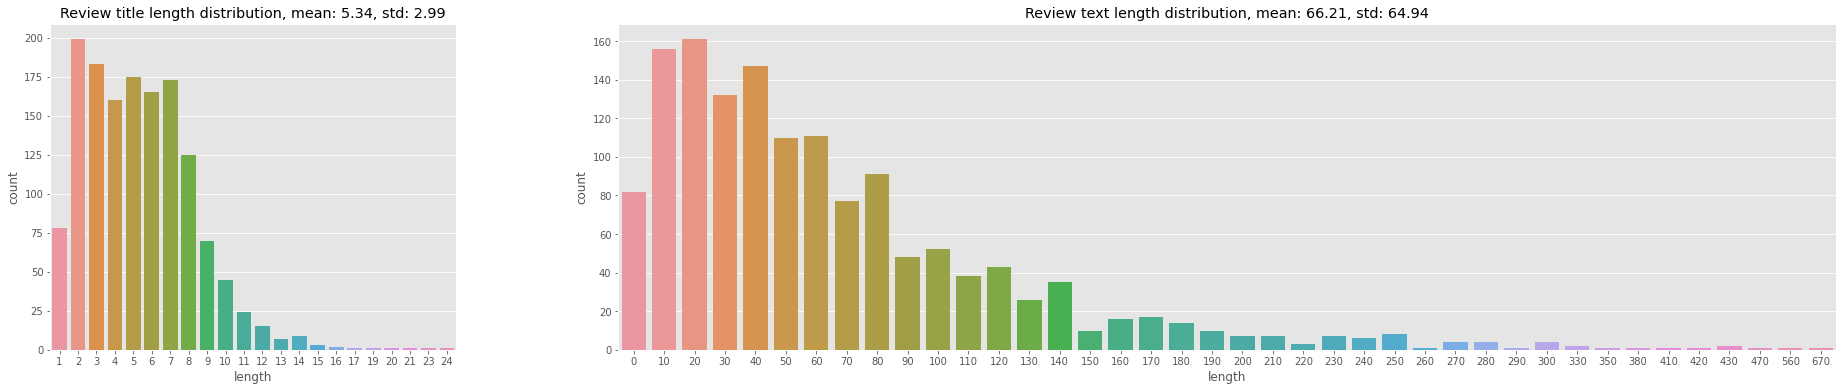

In [99]:
titles_list = [title for title in reviews.title.str.split()]
titles_lengths = pd.DataFrame(data={"length": [len(title) for title in titles_list]})

texts_list = [text for text in reviews.text.str.split()]
texts_lengths = pd.DataFrame(data={"length": [len(text) for text in texts_list]}).round(-1)

fig, axs = plt.subplots(1, 2, figsize=(32, 6), gridspec_kw={'width_ratios': [1, 3]})
sns.countplot(x="length", data=titles_lengths, ax=axs[0])
axs[0].set_title(f"Review title length distribution, mean: {titles_lengths.mean().values[0]:,.2f}, std: {titles_lengths.std().values[0]:,.2f}")
sns.countplot(x="length", data=texts_lengths, ax=axs[1])
axs[1].set_title(f"Review text length distribution, mean: {texts_lengths.mean().values[0]:,.2f}, std: {texts_lengths.std().values[0]:,.2f}");

## 4. Reviews text preprocessing

- Define helper functions.

In [149]:
def tokenize(docs: pd.Series, min_len: int = 2, max_len: int = 30) -> List[List[str]]:
    return [simple_preprocess(doc, deacc=True, min_len=min_len, max_len=max_len) for doc in docs]
        
def lemmatize(tokenized_docs: List[List[str]], lemmatizer: Any) -> List[List[str]]:
    res = [[lemmatizer.lemmatize(lemmatizer.lemmatize(token, pos='v'), pos='n')
            for token in doc] for doc in tokenized_docs]
    return res

def add_trigram_phrases(lemmatized_docs: List[List[str]], min_count: int, threshold: int) -> List[List[str]]:
    bigram_model = Phrases(lemmatized_docs, min_count=min_count, threshold=threshold)
    trigram_model = Phrases(bigram_model[lemmatized_docs], min_count=min_count, threshold=threshold)
    res = list(trigram_model[bigram_model[lemmatized_docs]])
    return res
     
def filter_stopwords(phrased_docs: List[List[str]]) -> List[List[str]]:
    return [[token for token in doc if token not in STOPWORDS] for doc in phrased_docs]   
    
def filter_short_tokens(filtered_stopwords_docs: List[List[str]], min_len: int = 3) -> List[List[str]]:
    return [[token for token in doc if len(token) >= min_len] for doc in filtered_stopwords_docs]

- Apply tokenization, deaccentation, min-length filtering, stop-words filtering, **WordNet** lemmatization to each review text to produce tokenized documents, i.e. list of lists of tokens. We decided not to use stemmer, because we wanted to keep real words in the dictionary instead of trimmed ones in order to easily interpret the predicted topics.

In [150]:
lemmatizer = WordNetLemmatizer()
docs = reviews.text

tokenized_docs = tokenize(docs, min_len=2, max_len=20)
lemmatized_docs = lemmatize(tokenized_docs, lemmatizer)
phrased_docs = add_trigram_phrases(lemmatized_docs, min_count=2, threshold=10)
filtered_stopwords_docs = filter_stopwords(phrased_docs)
processed_docs = filter_short_tokens(filtered_stopwords_docs, min_len=3)

## 5. Gensim LDA model

- Define helper function.

In [140]:
def calc_coherence_metric(corpus, dictionary, topics, processed_docs, alpha, eta):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=topics,
                                           passes=10,
                                           alpha=alpha,
                                           eta=eta,
                                           chunksize=100,
                                           random_state=10)
    
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=processed_docs,
                                     corpus=corpus,
                                     coherence='c_v')
    
    return coherence_model.get_coherence()

- Plug tokenized documents into **gensim Dictionary** object and apply **filter_extremes function** filtering tokens that occur in less than 5 or in above 10% of documents. Then calculate **bag-of-words corpus** from the tokenized documents using the dictionary.

In [151]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=100_000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
corpus_size, dictionary_size = len(bow_corpus), len(dictionary)

print(f"Number of documents in the bow corpus is: {corpus_size}")
print(f"Number of words/tokens in the dictionary is: {dictionary_size}")

Number of documents in the bow corpus is: 1439
Number of words/tokens in the dictionary is: 1546


- Check how the bag of words looks for a sample document selected from the corpus.

In [142]:
doc = 1000
bow_doc_x = bow_corpus[doc]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], dictionary[bow_doc_x[i][0]], bow_doc_x[i][1]))

Word 45 ("turn_out") appears 1 time.
Word 138 ("minute") appears 1 time.
Word 161 ("wait") appears 1 time.
Word 1377 ("driver") appears 1 time.
Word 1535 ("gatwick") appears 1 time.


- Train the LDA model using bow_corpus and dictionary objects, using grid search method validated on two distinct corpus variations.

In [106]:
# min_topics, max_topics, step = 4, 13, 1

# topics_range = range(min_topics, max_topics, step)
# alphas = list(np.arange(0.01, 1.1, 0.1)) + ["symmetric", "asymmetric"]
# etas = list(np.arange(0.01, 1.1, 0.1)) + ["symmetric"]

# corpus_sets = [bow_corpus, bow_corpus]
# corpus_titles = ['75% Corpus', '100% Corpus']
# model_results = {'corpuses': [], 'topics': [], 'alphas': [], 'etas': [], 'coherences': []}

# pbar = tqdm.tqdm(total=540)
# for i, corpus in enumerate(corpus_sets):
#     for topics in topics_range:
#         for alpha in alphas:
#             for eta in etas:
#                 coherence = calc_coherence_metric(corpus=corpus, dictionary=dictionary, topics=topics, processed_docs=processed_docs,
#                                                   alpha=alpha, eta=eta)

#                 model_results['corpuses'].append(corpus_titles[i])
#                 model_results['topics'].append(topics)
#                 model_results['alphas'].append(alpha)
#                 model_results['etas'].append(eta)
#                 model_results['coherences'].append(coherence)
#                 pbar.update(1)
                
# pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
# pbar.close()

In [152]:
num_topics = 10
    
lda_model = gensim.models.LdaModel(corpus=bow_corpus, 
                                   num_topics=num_topics, 
                                   id2word=dictionary,                                    
                                   passes=10,
                                   alpha=0.01,
                                   eta=0.01,
                                   minimum_probability=0.1,
                                   random_state=10)

coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, corpus=bow_corpus, coherence='c_v')
coherence = coherence_model.get_coherence()
print('Coherence Score: ', coherence)

Coherence Score:  0.3025536886277339


## 6. Topics analysis

- Define helper functions.

In [120]:
def topics_in_documents_as_df(topics_in_documents_list, documents_df, num_topics, period_col="year"):
    res = pd.DataFrame(columns=range(num_topics))
    for i, document in enumerate(topics_in_documents_list):
        for topic_weight in document:
            res.loc[i, topic_weight[0]] = topic_weight[1]
        
    res = res.fillna(0)
    res["period"] = documents_df[period_col] 
    return res

def get_representative_docs_for_topic(topics_in_documents, documents_series, topic, n=10):
    indices = topics_in_documents.sort_values(by=topic, ascending=False)[topic].head(n).index 
    print(topics_in_documents.sort_values(by=topic, ascending=False)[topic].head(n))
    for i in range(n):
        print(documents_series[indices].tolist()[i], '\n')

- Display the identified topics and their most relevant words/tokens.

In [153]:
for i, topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i) + ": "+ topic, '\n')

0: 0.013*"pay" + 0.012*"change" + 0.010*"station" + 0.010*"company" + 0.010*"people" + 0.008*"seat" + 0.008*"terrible_service" + 0.007*"leave" + 0.006*"actually" + 0.006*"fare" 

1: 0.015*"seat" + 0.014*"try" + 0.011*"company" + 0.009*"passenger" + 0.009*"money" + 0.008*"absolutely" + 0.008*"way" + 0.008*"due_to" + 0.007*"website" + 0.007*"customer" 

2: 0.010*"late" + 0.008*"carriage" + 0.008*"first_class" + 0.008*"station" + 0.008*"tell" + 0.008*"customer" + 0.007*"southern_rail" + 0.007*"week" + 0.007*"reply" + 0.006*"complaint" 

3: 0.018*"virgin" + 0.018*"seat" + 0.010*"need" + 0.009*"like" + 0.008*"offer" + 0.008*"email" + 0.008*"virgin_train" + 0.007*"think" + 0.007*"out_of" + 0.007*"try" 

4: 0.018*"price" + 0.017*"customer_service" + 0.015*"seat" + 0.010*"first_class" + 0.010*"try" + 0.010*"change" + 0.008*"virgin" + 0.008*"customer" + 0.008*"pay" + 0.008*"phone" 

5: 0.012*"buy" + 0.011*"virgin_train" + 0.011*"virgin" + 0.009*"station" + 0.009*"first_class" + 0.008*"seat" + 0

**Topis we identified in the data are as follows:**

0. Customer service 
1. Seats/reservations and staff complaints
2. Eurostar complaints
3. Class and food complaints
4. Delays, cancellations, overcrowdedness

- Visualise identified topics using `pyLDAvis` package. **We can see that topics are well separated using PCA (principal component analysis).**

In [154]:
data = gensimvis.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(data)

- Generate documents-topics "TF-IDF-like" matrix (dataframe) useful for further visualisations.  

In [155]:
topics_in_documents_list = [lda_model[bow_corpus[i]] for i, _ in enumerate(bow_corpus)]
topics_in_documents = topics_in_documents_as_df(topics_in_documents_list, documents_df=reviews, num_topics=num_topics, period_col="year")

- Get top 10 representative documents for selected topic.

In [157]:
# get_representative_docs_for_topic(topics_in_documents, documents_series=reviews.text, topic=0, n=10)

- Display heatmap plot showing distribution of topics among documents, ordered by documents primary topic. From the colors of the heatmap, we can conclude that primary topics do not have always very high probability in each of the documents (documents are about more than one topic in those cases).

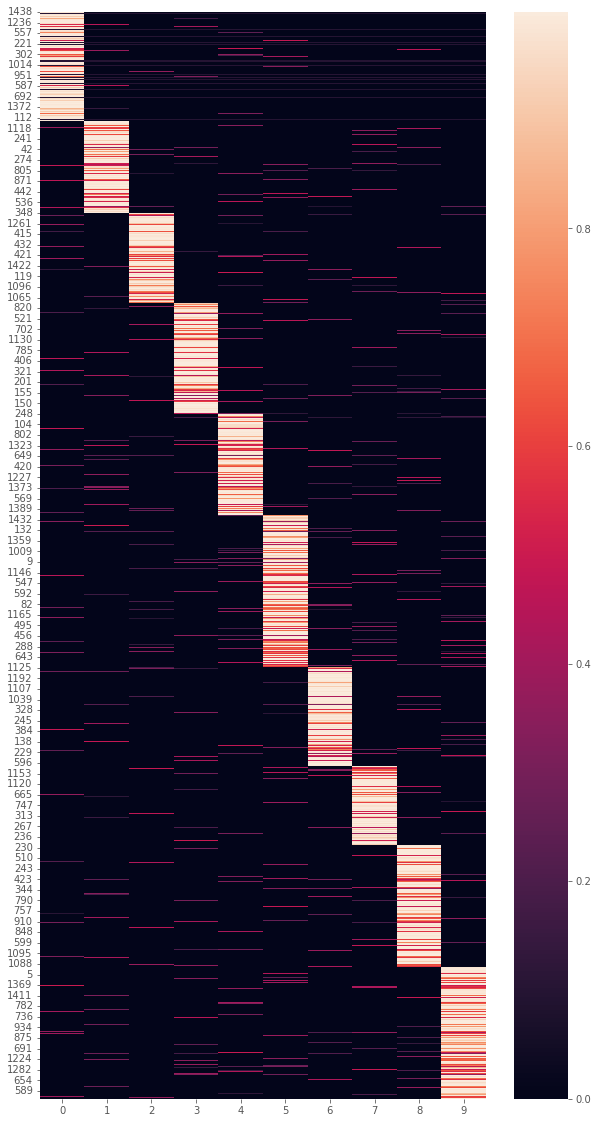

In [156]:
heatmap_df = topics_in_documents[range(num_topics)]

fig, ax = plt.subplots(1, 1, figsize=(10, 20))
sns.heatmap(heatmap_df.loc[heatmap_df.idxmax(axis=1).sort_values().index], ax=ax);

- Display **primary topic distribution** (i.e. the most relevant topic for each document) plot over years. We see generally that most of the topics remained relevant for the whole period of 4 years. Regarding the question of whether the topics changed over years, this question could effectively be answered if we modelled each year separately and compared topics across years - this excercise was quite time demanding so I just outlined the idea/direction I would pursue. However, given the low number of observations and uncertainty in establishing the right labels for each identified topic, it would be relatively imprecise comparison or would require deeper analysis of underlying data.

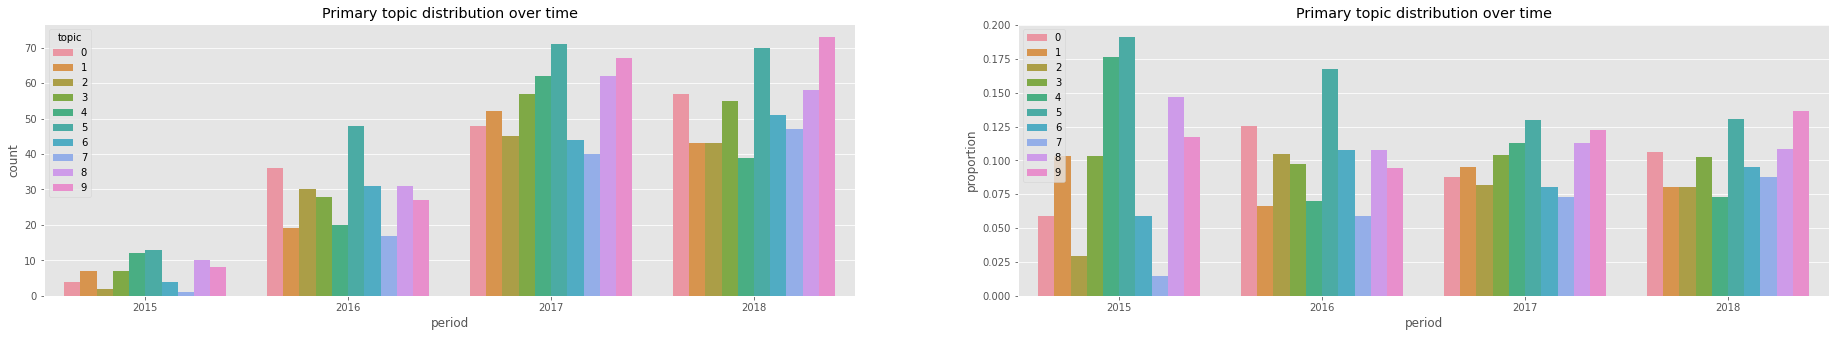

In [148]:
primary_topics = pd.DataFrame(data={"topic": topics_in_documents[range(num_topics)].idxmax(axis=1), "period": topics_in_documents.period})
grouped = primary_topics.groupby(["period", "topic"]).agg(count=("topic", "count")).reset_index()
grouped["proportion"] = grouped["count"]/grouped.groupby("period")["count"].transform("sum")

fig, axs = plt.subplots(1, 2, figsize=(32, 5))
axs[0] = sns.countplot(x="period", hue="topic", data=primary_topics, ax=axs[0])
axs[0].set_title("Primary topic distribution over time");

axs[1] = sns.barplot(x="period", y="proportion", hue="topic", data=grouped, ax=axs[1])
axs[1].set_title("Primary topic distribution over time");
plt.legend(loc='upper left');

In [ ]:
# def preprocess_one(doc, lemmatizer, min_len=2, max_len=20):
#     tokens = gensim.utils.simple_preprocess(doc, deacc=True, min_len=min_len, max_len=max_len)
#     after_stop_words = []
#     for token in tokens:
#         if token not in gensim.parsing.preprocessing.STOPWORDS:
#             after_stop_words.append(token)
    
#     result = []
#     for token in after_stop_words:
#         result.append(lemmatizer.lemmatize(lemmatizer.lemmatize(token, pos='v'), pos='n'))
#     return result


# def preprocess(docs, lemmatizer, min_len=3, max_len=20):
#     return [preprocess_one(doc, lemmatizer, min_len, max_len) for doc in docs]


# def topics_in_documents_as_df(topics_in_documents_list, documents_df, num_topics, period_col="year"):
#     res = pd.DataFrame(columns=range(num_topics))
#     for i, document in enumerate(topics_in_documents_list):
#         for topic_weight in document:
#             res.loc[i, topic_weight[0]] = topic_weight[1]
        
#     res = res.fillna(0)
#     res["period"] = documents_df[period_col] 
#     return res

# def get_representative_docs_for_topic(topics_in_documents, documents_series, topic, n=10):
#     indices = topics_in_documents.sort_values(by=topic, ascending=False)[topic].head(n).index 
#     print(topics_in_documents.sort_values(by=topic, ascending=False)[topic].head(n))
#     for i in range(n):
#         print(documents_series[indices].tolist()[i], '\n')


# processed_docs = preprocess(docs, lemmatizer=lemmatizer, min_len=2, max_len=20)